# Hate Speech and Offensive Language Detection

This dataset is a meticulously curated collection of annotated tweets with the specific purpose of detecting hate speech and offensive language. The dataset primarily consists of English tweets and is designed to train machine learning models or algorithms in the task of hate speech detection. 
The dataset includes several columns that provide valuable information for understanding each tweet's classification. The column count represents the total number of annotations provided for each tweet, whereas hate_speech_count signifies how many annotations classified a particular tweet as hate speech. On the other hand, offensive_language_count indicates the number of annotations categorizing a tweet as containing offensive language. Additionally, neither_count denotes how many annotations identified a tweet as neither hate speech nor offensive language.

Source: https://www.kaggle.com/datasets/thedevastator/hate-speech-and-offensive-language-detection

In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re             
import string

In [2]:
df = pd.read_csv('tweets_hate.csv')
df.head()

count  hate_speech_count  offensive_language_count  neither_count  class  \
0      3                  0                         0              3      2   
1      3                  0                         3              0      1   
2      3                  0                         3              0      1   
3      3                  0                         2              1      1   
4      6                  0                         6              0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [3]:
df['class'].value_counts()

1    19190
2     4163
0     1430
Name: class, dtype: int64

The dataset is unbalanced, so the sampling must apply greater weights to the minority classes:

In [4]:
weights = {0: 0.90, 1: 0.016, 2: 0.084}

df_samp = df.sample(n=4200, weights= df['class'].map(weights), random_state=42)

In [5]:
df_samp['class'].value_counts()

0    1414
1    1406
2    1380
Name: class, dtype: int64

In [6]:
df_samp = df_samp.reset_index(drop = True)

**Class definitions:**

0: Hate speech

1: Offensive language

2: Neither

In [7]:
df_samp.isnull().sum()

count                       0
hate_speech_count           0
offensive_language_count    0
neither_count               0
class                       0
tweet                       0
dtype: int64

In [8]:
df_samp.duplicated().sum()

0

In [9]:
df_ = df_samp[['class','tweet']].copy()
df_

class                                              tweet
0         0  @sizzurp__ @bootyacid @ILIKECATS74 @yoPapi_chu...
1         0  You old bitter,salty ass niccas make my flesh ...
2         0         RT @PeterpandaCat: @savanigga Sav is a fag
3         0          Need a bitch to drop it down for a niggah
4         0                        @Im_Thirst randies are fags
...     ...                                                ...
4195      2  Omer Asik so trash on the offensive side of th...
4196      2  @mimi_sanabria I really did, right off my bed....
4197      2  RT @Smart_Cookie86: If I had to pick a Preside...
4198      2  RT @LucentVariable: @TonyJRodriguez friendly r...
4199      1  thats top off, pop off, im with my dogs like s...

[4200 rows x 2 columns]

## Preparation of the texts:

Using regular expressions (regex) to remove URL, usernames, alphanumeric characters, and escaping entities:

In [10]:
def remove_(text):
    # Remove URLs
    clean_text = re.sub(r'http[s]?://\S+|www\.\S+', '', text)

    # Remove usernames
    clean_text2 = re.sub(r'@\w+', '', clean_text)
    
    # Remove alphanumeric characters
    clean_text3 = re.sub(r'\S*\d\S*', '', clean_text2)
    
    # Remove escaping entities:
    clean_text4 = re.sub(r'&[^;]+;', '', clean_text3)

    return clean_text4

In [11]:
# To apply to the entire column "in cascade", we use the "apply" function

df_['tweet_clean'] = df_['tweet'].apply(remove_)

In [12]:
df_

class                                              tweet  \
0         0  @sizzurp__ @bootyacid @ILIKECATS74 @yoPapi_chu...   
1         0  You old bitter,salty ass niccas make my flesh ...   
2         0         RT @PeterpandaCat: @savanigga Sav is a fag   
3         0          Need a bitch to drop it down for a niggah   
4         0                        @Im_Thirst randies are fags   
...     ...                                                ...   
4195      2  Omer Asik so trash on the offensive side of th...   
4196      2  @mimi_sanabria I really did, right off my bed....   
4197      2  RT @Smart_Cookie86: If I had to pick a Preside...   
4198      2  RT @LucentVariable: @TonyJRodriguez friendly r...   
4199      1  thats top off, pop off, im with my dogs like s...   

                                            tweet_clean  
0                           go back to lego club faggot  
1     You old bitter,salty ass niccas make my flesh ...  
2                                    RT :  Sav is a fag  
3             Need a bitch to drop it down for a niggah  
4                                      randies are fags  
...                                                 ...  
4195  Omer Asik so trash on the offensive side of th...  
4196   I really did, right off my bed. Where you put...  
4197  RT : If I had to pick a President of the Uncle...  
4198  RT :  friendly reminder that you shouldn't try...  
4199  thats top off, pop off, im with my dogs like s...  

[4200 rows x 3 columns]

In [13]:
import spacy

Loading a pre-trained model:

In [14]:
model_spacy = spacy.load('en_core_web_sm')    

Adding "RT" to the stopword list:

In [15]:
model_spacy.Defaults.stop_words.add("RT")

In [16]:
print("RT" in model_spacy.Defaults.stop_words)

True


Applying the model to a text:

In [17]:
text= df_['tweet'][2]
text_spacy = list(model_spacy(text))
text_spacy[0]

RT

In [18]:
text_spacy[0].is_stop

False

Although the expression "RT" was included in the list of "Stop Words", this expression was not removed from the texts.

To solve this problem, we include a list comprehension (text_space2) in the function below.

In [19]:
def preproc_nlp(text, model_spacy =model_spacy):
        
    # Application of the model 
    text_spacy = list(model_spacy(text))
    text_spacy2 = list([token for token in text_spacy if token.text != 'RT'])
           
    # List of tokens after preparation
    text_result = list()
    
    for t in text_spacy2:
        if t.is_punct:
            continue
        if t.is_digit:
            continue
        if t.is_space:
            continue
        if t.is_stop:
            continue
        # Lowercase conversion and lemmatization
        text_result.append(t.lemma_.lower())    
  
    text_result = ' '.join(text_result)
    
    return text_result

In [20]:
# To apply to the entire column "in cascade", we use the "apply" function

df_['tweet_clean2'] = df_['tweet_clean'].apply(preproc_nlp)

In [21]:
df_

class                                              tweet  \
0         0  @sizzurp__ @bootyacid @ILIKECATS74 @yoPapi_chu...   
1         0  You old bitter,salty ass niccas make my flesh ...   
2         0         RT @PeterpandaCat: @savanigga Sav is a fag   
3         0          Need a bitch to drop it down for a niggah   
4         0                        @Im_Thirst randies are fags   
...     ...                                                ...   
4195      2  Omer Asik so trash on the offensive side of th...   
4196      2  @mimi_sanabria I really did, right off my bed....   
4197      2  RT @Smart_Cookie86: If I had to pick a Preside...   
4198      2  RT @LucentVariable: @TonyJRodriguez friendly r...   
4199      1  thats top off, pop off, im with my dogs like s...   

                                            tweet_clean  \
0                           go back to lego club faggot   
1     You old bitter,salty ass niccas make my flesh ...   
2                                    RT :  Sav is a fag   
3             Need a bitch to drop it down for a niggah   
4                                      randies are fags   
...                                                 ...   
4195  Omer Asik so trash on the offensive side of th...   
4196   I really did, right off my bed. Where you put...   
4197  RT : If I had to pick a President of the Uncle...   
4198  RT :  friendly reminder that you shouldn't try...   
4199  thats top off, pop off, im with my dogs like s...   

                                           tweet_clean2  
0                                      lego club faggot  
1     old bitter salty ass niccas flesh crawl bone b...  
2                                               sav fag  
3                                need bitch drop niggah  
4                                            randie fag  
...                                                 ...  
4195  omer asik trash offensive floor dude real life...  
4196        right bed dam yellow starburst throw window  
4197  pick president uncle tom association pick larr...  
4198                     friendly reminder try sex bird  
4199  s pop be dog like stewie griffin bitch hear li...  

[4200 rows x 4 columns]

Transformation into tokens:

In [22]:
from gensim.utils import simple_preprocess

In [23]:
df_['tweet_clean_tokens'] = [simple_preprocess(line) for line in df_['tweet_clean2']] 

In [24]:
df_

class                                              tweet  \
0         0  @sizzurp__ @bootyacid @ILIKECATS74 @yoPapi_chu...   
1         0  You old bitter,salty ass niccas make my flesh ...   
2         0         RT @PeterpandaCat: @savanigga Sav is a fag   
3         0          Need a bitch to drop it down for a niggah   
4         0                        @Im_Thirst randies are fags   
...     ...                                                ...   
4195      2  Omer Asik so trash on the offensive side of th...   
4196      2  @mimi_sanabria I really did, right off my bed....   
4197      2  RT @Smart_Cookie86: If I had to pick a Preside...   
4198      2  RT @LucentVariable: @TonyJRodriguez friendly r...   
4199      1  thats top off, pop off, im with my dogs like s...   

                                            tweet_clean  \
0                           go back to lego club faggot   
1     You old bitter,salty ass niccas make my flesh ...   
2                                    RT :  Sav is a fag   
3             Need a bitch to drop it down for a niggah   
4                                      randies are fags   
...                                                 ...   
4195  Omer Asik so trash on the offensive side of th...   
4196   I really did, right off my bed. Where you put...   
4197  RT : If I had to pick a President of the Uncle...   
4198  RT :  friendly reminder that you shouldn't try...   
4199  thats top off, pop off, im with my dogs like s...   

                                           tweet_clean2  \
0                                      lego club faggot   
1     old bitter salty ass niccas flesh crawl bone b...   
2                                               sav fag   
3                                need bitch drop niggah   
4                                            randie fag   
...                                                 ...   
4195  omer asik trash offensive floor dude real life...   
4196        right bed dam yellow starburst throw window   
4197  pick president uncle tom association pick larr...   
4198                     friendly reminder try sex bird   
4199  s pop be dog like stewie griffin bitch hear li...   

                                     tweet_clean_tokens  
0                                  [lego, club, faggot]  
1     [old, bitter, salty, ass, niccas, flesh, crawl...  
2                                            [sav, fag]  
3                           [need, bitch, drop, niggah]  
4                                         [randie, fag]  
...                                                 ...  
4195  [omer, asik, trash, offensive, floor, dude, re...  
4196  [right, bed, dam, yellow, starburst, throw, wi...  
4197  [pick, president, uncle, tom, association, pic...  
4198               [friendly, reminder, try, sex, bird]  
4199  [pop, be, dog, like, stewie, griffin, bitch, h...  

[4200 rows x 5 columns]

## Exploratory Text Analysis: WordCloud

In [25]:
from wordcloud import WordCloud

In [26]:
def plot_wordcloud(wc, title):
    plt.figure(figsize=(20,10))
    plt.imshow(wc)                # imshow display data as an image
    plt.axis("off")
    plt.title(title, fontsize=24)

In [27]:
wc_text = WordCloud(width = 1000, height = 500)\
        .generate_from_text(' '.join(df_['tweet_clean2'].to_list()))

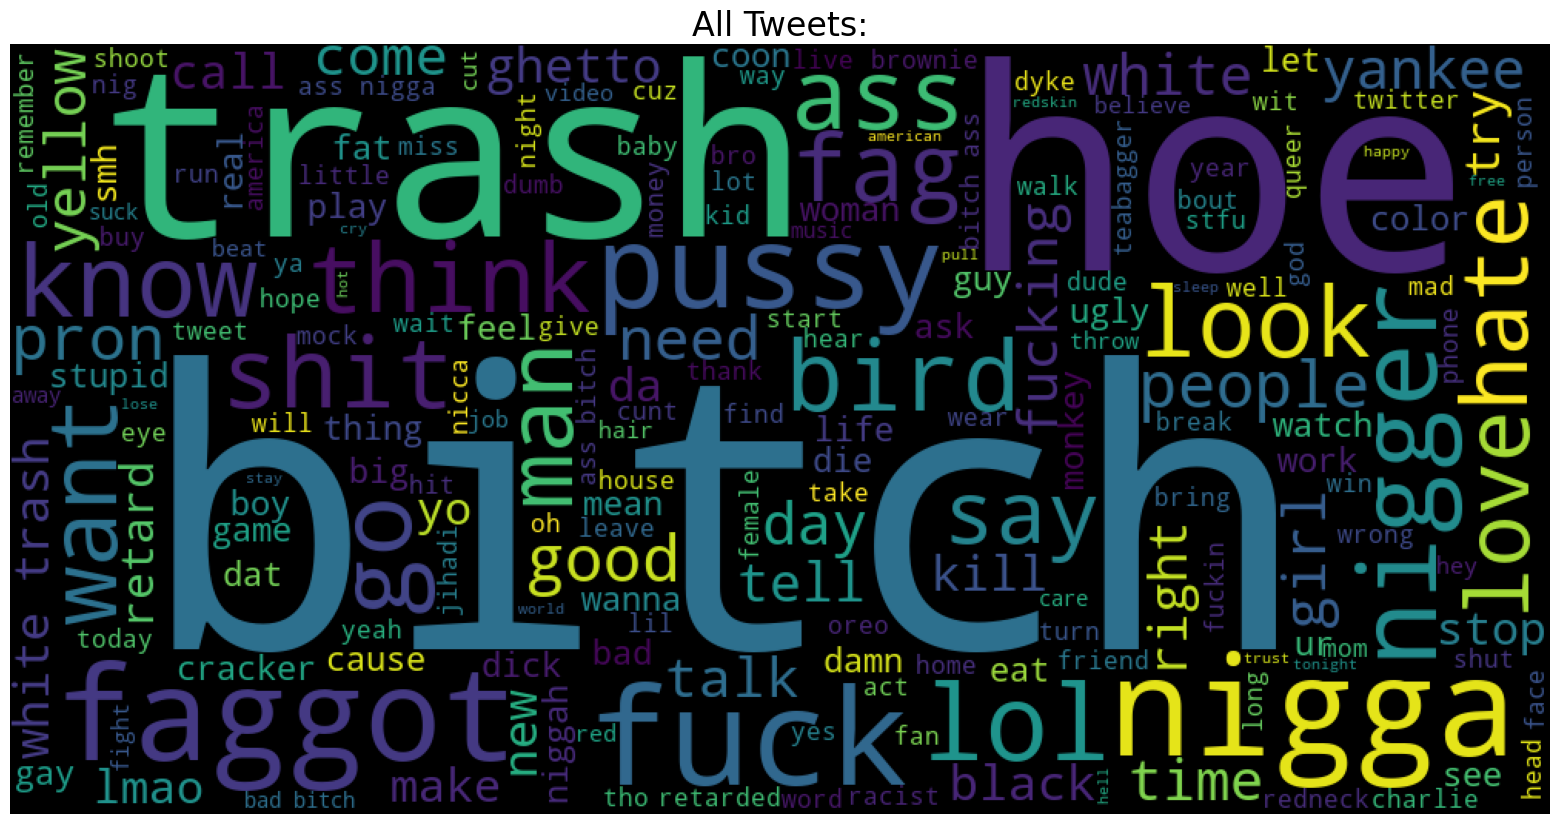

In [28]:
plot_wordcloud(wc_text, 'All Tweets:')

### Segmenting into the different classes:

0: Hate speech

1: Offensive language

2: Neither

In [29]:
df_0 = df_[df_['class']==0]

wc_text_0 = WordCloud(width = 1000, height = 500)\
        .generate_from_text(' '.join(df_0['tweet_clean2'].to_list()))

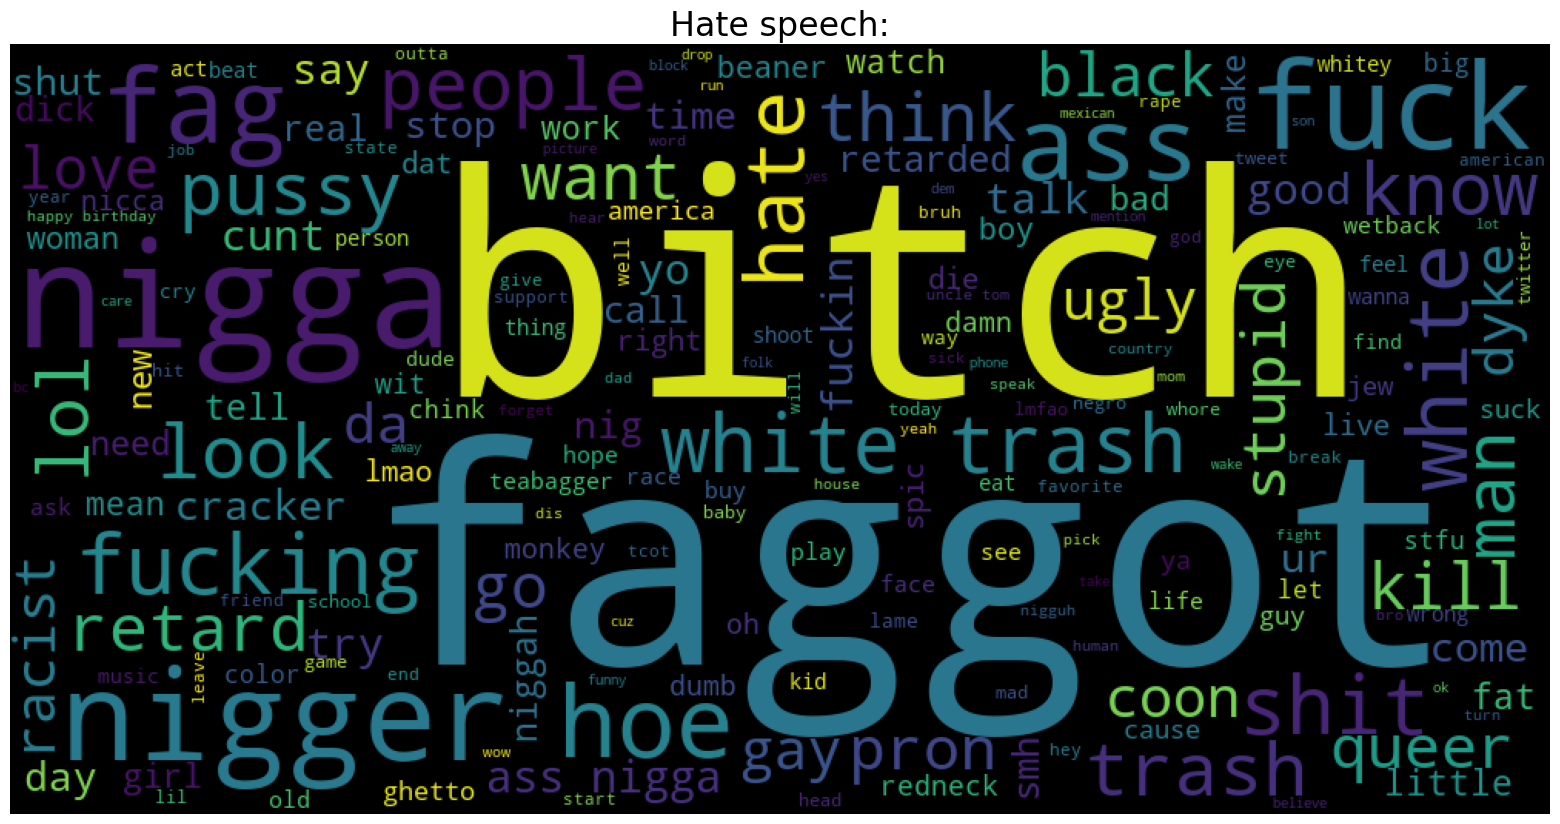

In [30]:
plot_wordcloud(wc_text_0, 'Hate speech:')

In [31]:
df_1 = df_[df_['class']==1]

wc_text_1 = WordCloud(width = 1000, height = 500)\
        .generate_from_text(' '.join(df_1['tweet_clean2'].to_list()))

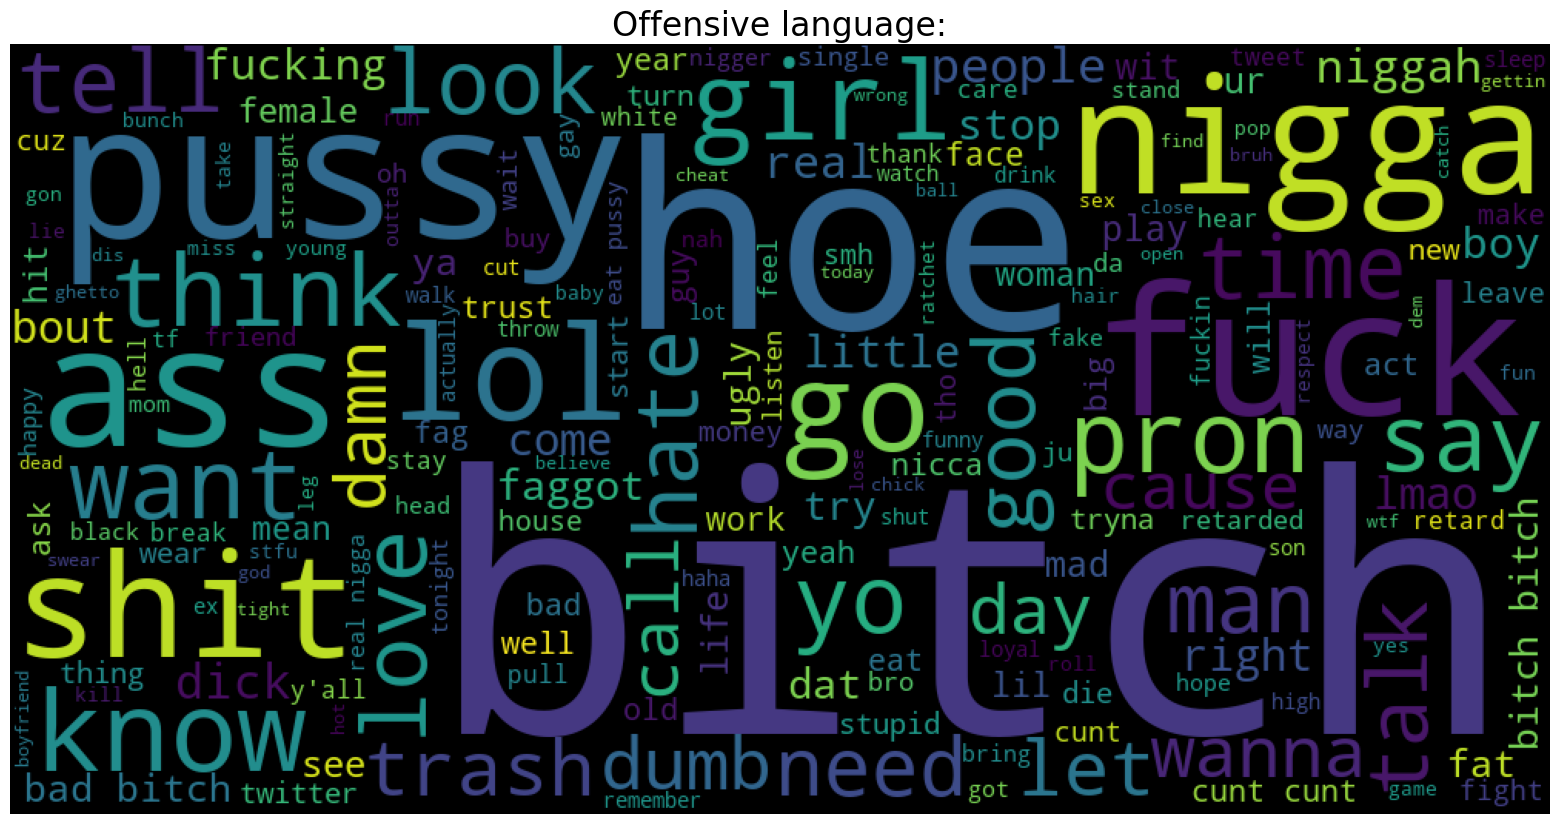

In [32]:
plot_wordcloud(wc_text_1, 'Offensive language:')

In [33]:
df_2 = df_[df_['class']==2]

wc_text_2 = WordCloud(width = 1000, height = 500)\
        .generate_from_text(' '.join(df_2['tweet_clean2'].to_list()))

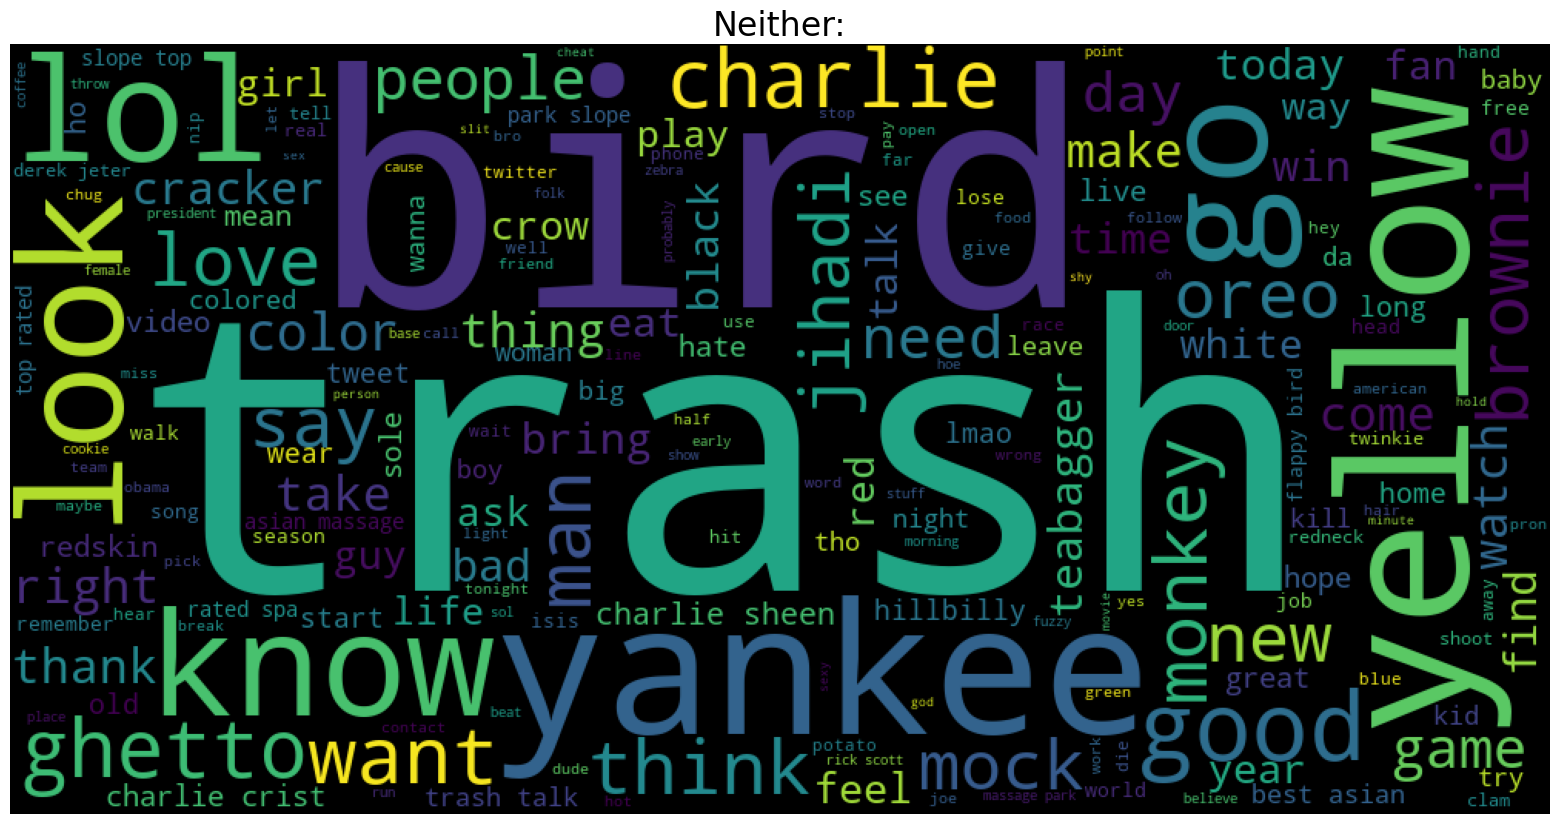

In [34]:
plot_wordcloud(wc_text_2, 'Neither:')

## Vector representation of the texts:

Word Embedding (Word2Vec)

### Obtaining the vector representation with a pre-trained Word2Vec model:

[Modelo Mikolov](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [35]:
from gensim.models import KeyedVectors

In [36]:
filename = 'GoogleNews-vectors-negative300.bin.gz' 
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [37]:
df_.isnull().sum()

class                 0
tweet                 0
tweet_clean           0
tweet_clean2          0
tweet_clean_tokens    0
dtype: int64

In [38]:
def aplica_w2v(df, text_tokens, model):
    df_w2v = pd.DataFrame()

    for index, row in df.iterrows():
        temp = pd.DataFrame()
        for token in row[text_tokens]:
            try:
                w2v_token = model[token]                
                temp = temp.append(pd.Series(w2v_token), ignore_index=True) 
            except KeyError:
                pass  
            
        if not temp.empty:
            df_w2v = df_w2v.append(temp.mean(), ignore_index=True)
        else:
            df_w2v = df_w2v.append(pd.Series([0]*model.vector_size), ignore_index=True)
        
    df_w2v.index = df.index

    return df_w2v

In [39]:
df_w2v = aplica_w2v(df_,'tweet_clean_tokens', model)

### Obtaining the vector representation with a custom Word2Vec model:

In [40]:
from gensim.models import Word2Vec 

In [41]:
def new_model(sentences, size, window, min_count):
    
    new_model = Word2Vec(sentences= sentences, 
                        size= size, 
                        window= window, 
                        min_count= min_count, 
                        workers=6,    
                        sg=1,         
                        iter=100)
    return new_model

In [42]:
new_model_1 = new_model(df_['tweet_clean_tokens'], 300, 5, 1)

In [43]:
new_model_2 = new_model(df_['tweet_clean_tokens'], 300, 5, 2)

In [44]:
new_model_3 = new_model(df_['tweet_clean_tokens'], 300, 3, 2)

In [45]:
new_model_4 = new_model(df_['tweet_clean_tokens'], 300, 3, 1)

Transformation of texts using the new models:

In [46]:
df_w2v_new1 = aplica_w2v(df_,'tweet_clean_tokens', new_model_1)
df_w2v_new2 = aplica_w2v(df_,'tweet_clean_tokens', new_model_2)
df_w2v_new3 = aplica_w2v(df_,'tweet_clean_tokens', new_model_3)
df_w2v_new4 = aplica_w2v(df_,'tweet_clean_tokens', new_model_4)

C:\Users\kaka_\AppData\Local\Temp\ipykernel_3368\3598283792.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_token = model[token]


## Prediction Models: Training a classification model

In [47]:
from sklearn.model_selection import train_test_split

### Preparing the data for training:

Defining the features set (x) and the target (y):

In [48]:
y = df_['class']

In [49]:
x_0 = df_w2v.copy()
x_1 = df_w2v_new1.copy()
x_2 = df_w2v_new2.copy()
x_3 = df_w2v_new3.copy()
x_4 = df_w2v_new4.copy()

Dividing into training, test and validation (function format):

In [50]:
def division (x, y):

    x_train_, x_test, y_train_, y_test = train_test_split(x, y, 
                                                        test_size= 0.30,
                                                        random_state= 42,
                                                         stratify= y) 
    
    x_train, x_valid, y_train, y_valid = train_test_split(x_train_, y_train_, 
                                                        test_size= 0.20,
                                                        random_state= 42,
                                                         stratify= y_train_)    
    
    return x_train, x_test, y_train, y_test, x_valid, y_valid

In [51]:
x_train0, x_test0, y_train0, y_test0, x_valid0, y_valid0 = division (x_0, y)
x_train1, x_test1, y_train1, y_test1, x_valid1, y_valid1 = division (x_1, y)
x_train2, x_test2, y_train2, y_test2, x_valid2, y_valid2 = division (x_2, y)
x_train3, x_test3, y_train3, y_test3, x_valid3, y_valid3 = division (x_3, y)
x_train4, x_test4, y_train4, y_test4, x_valid4, y_valid4 = division (x_4, y)

Testing the maximum depth of a decision tree:


Before deciding what the possible hyperparametric space will be for models based on decision trees, it is important to check the maximum depth reached when the number of observations per leaf is limited. Minimum values of 100 and 200 observations per leaf were tested.

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [152]:
model_tree = DecisionTreeClassifier(max_depth=10, 
                                    min_samples_leaf=200,
                                    random_state=42)
model_tree.fit(x_train1, y_train1)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=200, random_state=42)

In [57]:
from sklearn import tree

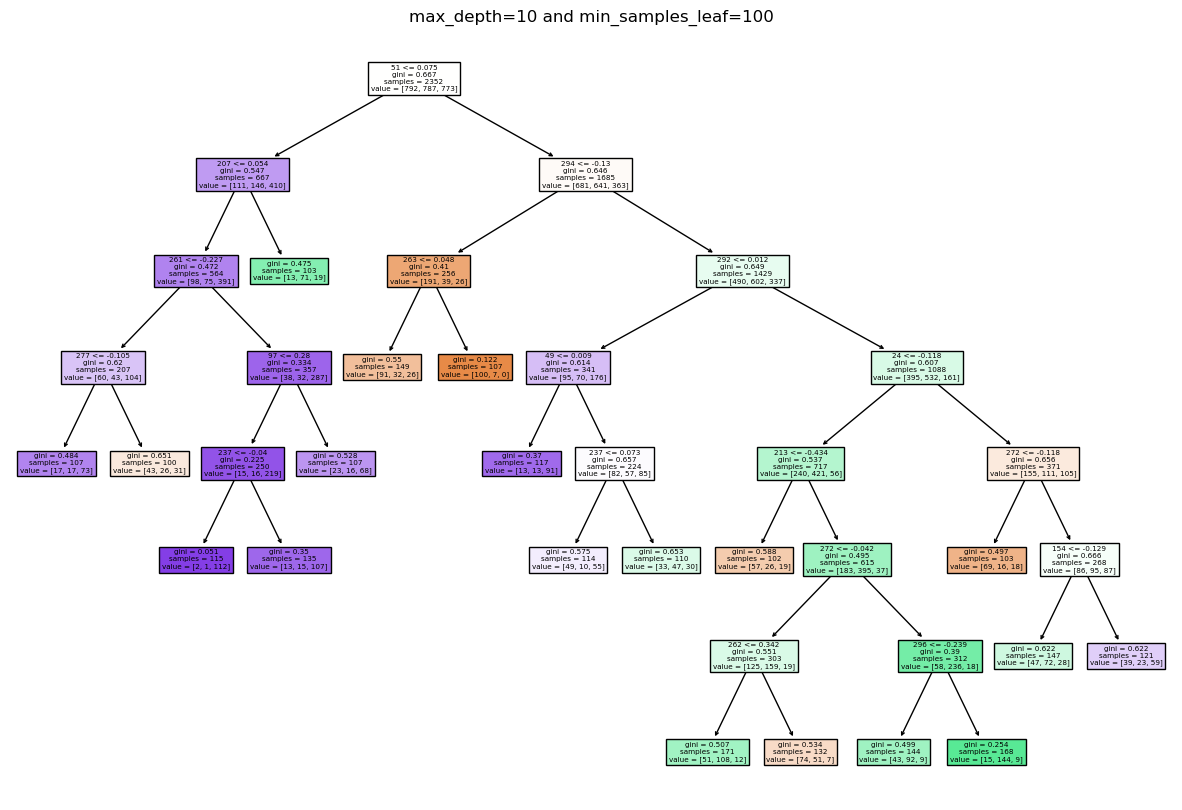

In [151]:
matplotlib.use('module://ipykernel.pylab.backend_inline')
fig = plt.figure(figsize=(15,10))

features = list(x_0.columns)
tree.plot_tree(model_tree,
               feature_names=features,
               filled=True);
plt.title("max_depth=10 and min_samples_leaf=100");
plt.show()

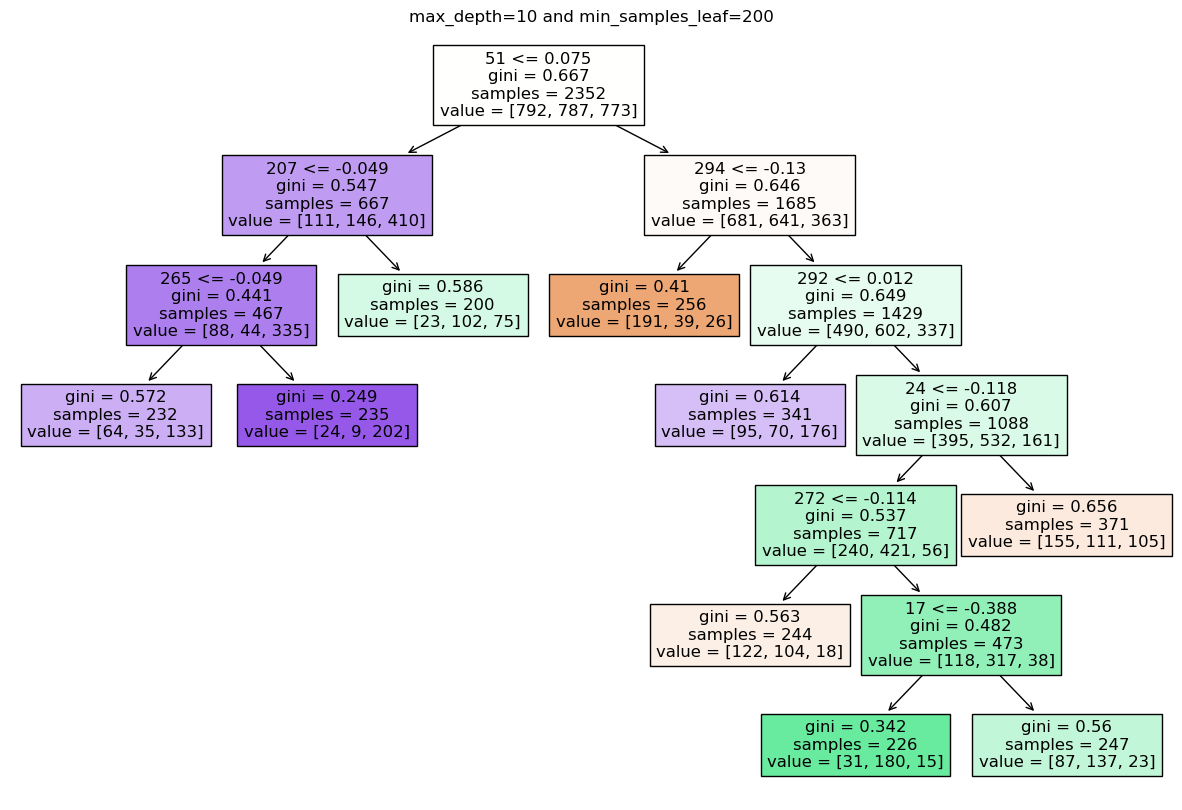

In [153]:
matplotlib.use('module://ipykernel.pylab.backend_inline')
fig = plt.figure(figsize=(15,10))

features = list(x_0.columns)
tree.plot_tree(model_tree,
               feature_names=features,
               filled=True);
plt.title("max_depth=10 and min_samples_leaf=200");
plt.show()

We verified that:

-The maximum depth is 6 when the minimum number of observations per leaf is 200.

-The maximum depth is 7 when the minimum number of observations per sheet is 100.

###  Gradient Boosting Classifier:

The Bayesian optimization technique was used to find the best hyperparameters for the model.

Defining the function structure of the prediction model:

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import math

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import sys
from hyperopt import space_eval

In [62]:
def train_boosting (estimators, lean_rate, min_leaf, sample, max_dp): 
    

    model_gbc = GradientBoostingClassifier(n_estimators = estimators, 
                                           learning_rate = lean_rate,
                                           min_samples_leaf = min_leaf,
                                           subsample = sample,           
                                           max_depth = max_dp,
                                           validation_fraction=0.3,
                                           random_state = 42)
                                            
    return model_gbc

Definition of the hyperparametric space:

In [63]:
est = np.arange(30, 110, 20) 

minlf = [100, 200]

leanrt = np.arange(0.20, 0.8, 0.10).round(decimals=2) 

samp = [0.3, 0.5, 0.8, 1.0] 
 
maxdp = np.arange(2, 8, 1) 

# Defining the dictionary of hyperparameters: 
param_grid = dict(estimators=est,
                  lean_rate=leanrt,
                  min_leaf=minlf,
                  sample =samp,
                  max_dp = maxdp)

In [64]:
bo_space = {'estimators': hp.choice('estimators', param_grid['estimators']),
            'lean_rate': hp.choice('lean_rate', param_grid['lean_rate']),
            'min_leaf': hp.choice('min_leaf', param_grid['min_leaf']),
            'sample': hp.choice('sample', param_grid['sample']),
            'max_dp': hp.choice('max_dp', param_grid['max_dp'])}

Defining the function that will be optimized:

The metric used to find the best hyperparameters was the F1 Score. This metric represents the balance between Precision and Recall. The objective was to obtain the highest possible value for F1 and at the same time obtain a minimum variation between training and test performances. Hypothetical points were considered in a 2D space, where "x" would be the value of the metric and "y" would be the difference between trainig and testing performance values. Considering this, the ideal point in this 2D space would be the point (1,0). Therefore, the distance between the real point and the ideal point should be as small as possible. The distance between 2 points in a 2D space is called The "Euclidean Distance". The Euclidean distance of the F1 Score was used as the loss of the optimization.

In [65]:
def bo_gbc(param, x_train, y_train, x_valid, y_valid):   

    print ('tested_hyperparameters: ', param)
    model_bo= train_boosting(estimators=param['estimators'], 
                                lean_rate=param['lean_rate'],
                                 min_leaf=param['min_leaf'],
                                sample =param['sample'],
                                max_dp=param['max_dp'])    
    
    model_bo.fit(x_train, y_train)    
      
    ypred_train = model_bo.predict(x_train)
    
    ypred_valid = model_bo.predict(x_valid)    

    f1_train = f1_score(y_train, ypred_train, average= 'micro')
    f1_valid = f1_score(y_valid, ypred_valid, average= 'micro')
    f1_Difference = (f1_train - f1_valid)/f1_train
    
    D_ = math.sqrt((f1_valid - 1)**2 + (f1_Difference - 0)**2)
        
    print('f1_valid :', f1_valid, 'f1_train :', f1_train)
    
    return {'loss': D_,'status': STATUS_OK}    

Creating a "wrapper fuction", which makes it possible to change the training set when necessary:

In [66]:
wrapper_fun0 = lambda param: bo_gbc(param, x_train0, y_train0, x_valid0, y_valid0)
wrapper_fun1 = lambda param: bo_gbc(param, x_train1, y_train1, x_valid1, y_valid1)
wrapper_fun2 = lambda param: bo_gbc(param, x_train2, y_train2, x_valid2, y_valid2)
wrapper_fun3 = lambda param: bo_gbc(param, x_train3, y_train3, x_valid3, y_valid3)
wrapper_fun4 = lambda param: bo_gbc(param, x_train4, y_train4, x_valid4, y_valid4)

Defining the parameters of the "fmin" optimization function:

In [67]:
trials = Trials()                  
bo_search_0 = fmin(fn= wrapper_fun0,       
                 space= bo_space,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 70, 'lean_rate': 0.3, 'max_dp': 4, 'min_leaf': 200, 'sample': 0.3}                                      
f1_valid :                                                                                                             
0.7091836734693878                                                                                                     
f1_train :                                                                                                             
0.8193027210884354                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 30, 'lean_rate': 0.3, 'max_dp': 2, 'min_leaf': 200, 'sample': 1.0}                                      
f1_valid :                              

In [68]:
trials = Trials()
bo_search_1 = fmin(fn= wrapper_fun1,       
                 space= bo_space,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 30, 'lean_rate': 0.2, 'max_dp': 2, 'min_leaf': 100, 'sample': 1.0}                                      
f1_valid :                                                                                                             
0.7363945578231292                                                                                                     
f1_train :                                                                                                             
0.8193027210884354                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 50, 'lean_rate': 0.8, 'max_dp': 6, 'min_leaf': 200, 'sample': 0.5}                                      
f1_valid :                              

In [69]:
trials = Trials()
bo_search_2 = fmin(fn= wrapper_fun2,       
                 space= bo_space,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 50, 'lean_rate': 0.3, 'max_dp': 7, 'min_leaf': 200, 'sample': 1.0}                                      
f1_valid :                                                                                                             
0.7585034013605442                                                                                                     
f1_train :                                                                                                             
0.9876700680272109                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 30, 'lean_rate': 0.6, 'max_dp': 5, 'min_leaf': 100, 'sample': 1.0}                                      
f1_valid :                              

In [70]:
trials = Trials()
bo_search_3 = fmin(fn= wrapper_fun3,       
                 space= bo_space,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 90, 'lean_rate': 0.8, 'max_dp': 3, 'min_leaf': 200, 'sample': 0.3}                                      
f1_valid :                                                                                                             
0.6649659863945578                                                                                                     
f1_train :                                                                                                             
0.8426870748299321                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 50, 'lean_rate': 0.8, 'max_dp': 4, 'min_leaf': 200, 'sample': 1.0}                                      
f1_valid :                              

In [71]:
trials = Trials()
bo_search_4 = fmin(fn= wrapper_fun4,       
                 space= bo_space,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 30, 'lean_rate': 0.2, 'max_dp': 4, 'min_leaf': 200, 'sample': 0.3}                                      
f1_valid :                                                                                                             
0.7346938775510203                                                                                                     
f1_train :                                                                                                             
0.7699829931972788                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 50, 'lean_rate': 0.5, 'max_dp': 5, 'min_leaf': 100, 'sample': 0.3}                                      
f1_valid :                              

Obtaining the best hyperparameters and fitting the chosen models:

In [72]:
def fit_gbc (bo_space, bo_search, x_train, y_train):
    
    bo_better = space_eval(bo_space, bo_search)  
    
    estimators = bo_better.get('estimators')
    lean_rate = bo_better.get('lean_rate')
    min_leaf = bo_better.get('min_leaf')
    sample = bo_better.get('sample')
    max_dp = bo_better.get('max_dp')
       
    model = train_boosting(estimators, lean_rate, min_leaf, sample, max_dp) 
    
    model.fit(x_train, y_train)
    
    return model

In [73]:
model_0g = fit_gbc (bo_space, bo_search_0, x_train0, y_train0)
model_1g = fit_gbc (bo_space, bo_search_1, x_train1, y_train1)
model_2g = fit_gbc (bo_space, bo_search_2, x_train2, y_train2)
model_3g = fit_gbc (bo_space, bo_search_3, x_train3, y_train3)
model_4g = fit_gbc (bo_space, bo_search_4, x_train4, y_train4)

In [74]:
import tensorflow as tf

Function to obtain the performance metrics with the testing and training base:

In [75]:
def performance (model, x_train, y_train, x_test, y_test):
    
    if isinstance(model, tf.keras.Model):
        ypred_train = np.argmax(model.predict(x_train), axis=1)
        ypred_proba_train = model.predict(x_train)

        ypred_test = np.argmax(model.predict(x_test), axis=1)
        ypred_proba_test = model.predict(x_test)
        
    else:
        ypred_train = model.predict(x_train)
        ypred_proba_train = model.predict_proba(x_train)

        ypred_test = model.predict(x_test)
        ypred_proba_test = model.predict_proba(x_test)      
        

    acc_train = accuracy_score(y_train, ypred_train)
    acc_test = accuracy_score(y_test, ypred_test)
    
    roc_train = roc_auc_score(y_train, ypred_proba_train, multi_class = 'ovr')
    roc_test = roc_auc_score(y_test, ypred_proba_test, multi_class = 'ovr')
    
    prec_train = precision_score(y_train, ypred_train, average= 'micro', zero_division=0)
    prec_test = precision_score(y_test, ypred_test, average= 'micro', zero_division=0)
    
    recl_train = recall_score(y_train, ypred_train, average= 'micro')
    recl_test = recall_score(y_test, ypred_test, average= 'micro')
    
    f1_train = f1_score(y_train, ypred_train, average= 'micro')
    f1_test = f1_score(y_test, ypred_test, average= 'micro')

    df_perf = pd.DataFrame({'Train':[acc_train, roc_train, prec_train, recl_train, f1_train],
                              'Test':[acc_test, roc_test, prec_test, recl_test, f1_test]},
                            index=['Accuracy','AUROC','Precision','Recall','F1'])
    
    df_perf['Variation'] = round(1 - df_perf['Test'] / df_perf['Train'], 2)
    
       
    return df_perf.round(decimals=2)

#### Obtaining a table with the general performances (mean of the performances of the three classes):

In [179]:
models_gbc = (model_0g, model_1g, model_2g, model_3g, model_4g)
models_names_gbc = ['model_0g', 'model_1g', 'model_2g', 'model_3g', 'model_4g']
x_train = (x_train0, x_train1, x_train2, x_train3, x_train4)
y_train = (y_train0, y_train1, y_train2, y_train3, y_train4)
x_test = (x_test0, x_test1, x_test2, x_test3, x_test4)
y_test = (y_test0, y_test1, y_test2, y_test3, y_test4)

In [77]:
def obtain_resume (models, models_names, x_train, y_train, x_test, y_test):
    
    performances = []

    for model, x_tr, y_tr, x_te, y_te in zip(models, x_train, y_train, x_test, y_test):
        
        performances.append(performance (model, x_tr, y_tr, x_te, y_te))    
   
    dfs = []
    for perf, name in zip(performances, models_names):
    
        dfs.append((pd.DataFrame(perf.stack(), columns=[name]).transpose()).drop('Train', axis=1, level=1))

    resume = pd.concat(dfs)    
    
    return resume

In [78]:
resume_gbc = obtain_resume (models_gbc, models_names_gbc, x_train, y_train, x_test, y_test)

In [79]:
resume_gbc

Accuracy           AUROC           Precision           Recall  \
             Test Variation  Test Variation      Test Variation   Test   
model_0g     0.71      0.14  0.86      0.09      0.71      0.14   0.71   
model_1g     0.74      0.10  0.89      0.06      0.74      0.10   0.74   
model_2g     0.73      0.07  0.87      0.05      0.73      0.07   0.73   
model_3g     0.75      0.16  0.88      0.09      0.75      0.16   0.75   
model_4g     0.72      0.07  0.88      0.04      0.72      0.07   0.72   

                      F1            
         Variation  Test Variation  
model_0g      0.14  0.71      0.14  
model_1g      0.10  0.74      0.10  
model_2g      0.07  0.73      0.07  
model_3g      0.16  0.75      0.16  
model_4g      0.07  0.72      0.07

#### Obtaining a table with the performances for each target class:

In [80]:
def resume_classes (models, models_names, x_train, y_train, x_test, y_test):
    
    prec_train = []
    prec_test = []
    recall_train = []
    recall_test = []

    for model, name, x_tr, y_tr, x_te, y_te in zip(models, models_names, x_train, y_train, x_test, y_test):
    
        if isinstance(model, tf.keras.Model):
            ypred_train = np.argmax(model.predict(x_tr), axis=1)       
            ypred_test = np.argmax(model.predict(x_te), axis=1)
              
        else:
            ypred_train = model.predict(x_tr) 
            ypred_test = model.predict(x_te)

        prec_train.append(precision_score(y_tr, ypred_train, average=None))
        recall_train.append(recall_score(y_tr, ypred_train, average=None))

        prec_test.append(precision_score(y_te, ypred_test, average=None))
        recall_test.append(recall_score(y_te, ypred_test, average=None))
    
    
    perform_list = [prec_train, prec_test, recall_train, recall_test]
    column_names = ['prec_train', 'prec_test', 'recall_train', 'recall_test']
    dfps = []
    
    for x, n in zip(perform_list, column_names):
    
        dfp = pd.DataFrame(x, index = models_names, columns= ['class_0','class_1','class_2'])
    
        dfp2 = pd.DataFrame(dfp.stack())
        dfp3 = dfp2.rename(columns={0: n})
        
        dfps.append(dfp3)
    
    perform_classes = pd.concat(dfps, axis=1)
    
    perform_classes['Variation_Precision'] = 1 - perform_classes['prec_test']/perform_classes['prec_train']
    perform_classes['Variation_Recall'] = 1 - perform_classes['recall_test']/perform_classes['recall_train']
    
    return perform_classes.drop(['prec_train','recall_train'], axis=1).round(decimals=2) 

In [180]:
res_class_gbc = resume_classes (models_gbc, models_names_gbc, x_train, y_train, x_test, y_test)
res_class_gbc

prec_test  recall_test  Variation_Precision  \
model_0g class_0       0.66         0.58                 0.19   
         class_1       0.74         0.72                 0.12   
         class_2       0.72         0.84                 0.13   
model_1g class_0       0.70         0.62                 0.11   
         class_1       0.73         0.73                 0.10   
         class_2       0.77         0.86                 0.11   
model_2g class_0       0.69         0.63                 0.08   
         class_1       0.74         0.72                 0.05   
         class_2       0.75         0.83                 0.08   
model_3g class_0       0.69         0.65                 0.22   
         class_1       0.76         0.74                 0.15   
         class_2       0.80         0.86                 0.12   
model_4g class_0       0.69         0.61                 0.05   
         class_1       0.72         0.71                 0.05   
         class_2       0.74         0.84                 0.10   

                  Variation_Recall  
model_0g class_0              0.21  
         class_1              0.16  
         class_2              0.08  
model_1g class_0              0.15  
         class_1              0.11  
         class_2              0.05  
model_2g class_0              0.09  
         class_1              0.08  
         class_2              0.04  
model_3g class_0              0.23  
         class_1              0.17  
         class_2              0.08  
model_4g class_0              0.09  
         class_1              0.09  
         class_2              0.03

### Bagging of Logistic Regression:

The Bayesian optimization technique was used to find the best hyperparameters for the model.

Defining the function structure of the prediction model:

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

In [83]:
def train_bagg_lr (estimators, samples, features): 
    
    model_base = LogisticRegression(max_iter=1000)   

    num_estimators = estimators          
  

    model_bagg_lr = BaggingClassifier(estimator = model_base, 
                                       n_estimators = num_estimators, 
                                       max_samples= samples,    
                                       max_features= features,   
                                       random_state = 42) 
    return model_bagg_lr

Definition of the hyperparametric space:

In [84]:
est = np.arange(50, 210, 50)

samp = [0.3, 0.5, 0.7, 1.0]

feat = [0.3, 0.5, 0.7, 1.0]

param_grid = dict(estimators=est,
                 samples = samp,
                 features = feat)

In [85]:
bo_space_bagg = {'estimators': hp.choice('estimators', param_grid['estimators']),
            'samples': hp.choice('samples', param_grid['samples']),
            'features': hp.choice('features', param_grid['features'])}

Defining the function that will be optimized:

In [86]:
def bo_bagg(param, x_train, y_train, x_valid, y_valid):   

    print ('tested_hyperparameters: ', param)
    model_bo = train_bagg_lr (estimators=param['estimators'],
                              samples=param['samples'], 
                              features=param['features'])
    
    model_bo.fit(x_train, y_train)    
      
    ypred_train = model_bo.predict(x_train)
    
    ypred_valid = model_bo.predict(x_valid)
    
    f1_train = f1_score(y_train, ypred_train, average= 'micro')
    f1_valid = f1_score(y_valid, ypred_valid, average= 'micro')
    f1_Difference = (f1_train - f1_valid)/f1_train
    
    D_ = math.sqrt((f1_valid - 1)**2 + (f1_Difference - 0)**2)
        
    print('f1_valid :', f1_valid, 'f1_train :', f1_train)
    
    return {'loss': D_,'status': STATUS_OK}    

In [87]:
wrapper_fun0 = lambda param: bo_bagg(param, x_train0, y_train0, x_valid0, y_valid0)
wrapper_fun1 = lambda param: bo_bagg(param, x_train1, y_train1, x_valid1, y_valid1)
wrapper_fun2 = lambda param: bo_bagg(param, x_train2, y_train2, x_valid2, y_valid2)
wrapper_fun3 = lambda param: bo_bagg(param, x_train3, y_train3, x_valid3, y_valid3)
wrapper_fun4 = lambda param: bo_bagg(param, x_train4, y_train4, x_valid4, y_valid4)

Defining the parameters of the "fmin" optimization function:

In [88]:
trials = Trials()                  
bo_search_0b = fmin(fn= wrapper_fun0,       
                 space= bo_space_bagg,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 150, 'features': 1.0, 'samples': 0.3}                                                                   
f1_valid :                                                                                                             
0.7193877551020408                                                                                                     
f1_train :                                                                                                             
0.7678571428571429                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 200, 'features': 0.3, 'samples': 0.5}                                                                   
f1_valid :                              

In [89]:
trials = Trials()                  
bo_search_1b = fmin(fn= wrapper_fun1,       
                 space= bo_space_bagg,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 50, 'features': 0.7, 'samples': 0.7}                                                                    
f1_valid :                                                                                                             
0.7806122448979592                                                                                                     
f1_train :                                                                                                             
0.8056972789115647                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 50, 'features': 0.5, 'samples': 0.3}                                                                    
f1_valid :                              

In [90]:
trials = Trials()                  
bo_search_2b = fmin(fn= wrapper_fun2,       
                 space= bo_space_bagg,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 200, 'features': 0.5, 'samples': 0.3}                                                                   
f1_valid :                                                                                                             
0.760204081632653                                                                                                      
f1_train :                                                                                                             
0.7869897959183674                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 200, 'features': 0.7, 'samples': 0.7}                                                                   
f1_valid :                              

In [91]:
trials = Trials()                  
bo_search_3b = fmin(fn= wrapper_fun3,       
                 space= bo_space_bagg,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 200, 'features': 0.7, 'samples': 0.5}                                                                   
f1_valid :                                                                                                             
0.760204081632653                                                                                                      
f1_train :                                                                                                             
0.7976190476190477                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 200, 'features': 1.0, 'samples': 1.0}                                                                   
f1_valid :                              

In [92]:
trials = Trials()                  
bo_search_4b = fmin(fn= wrapper_fun4,       
                 space= bo_space_bagg,  
                 algo=tpe.suggest,
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'estimators': 50, 'features': 0.5, 'samples': 0.7}                                                                    
f1_valid :                                                                                                             
0.7636054421768708                                                                                                     
f1_train :                                                                                                             
0.8065476190476192                                                                                                     
tested_hyperparameters:                                                                                                
{'estimators': 50, 'features': 0.5, 'samples': 0.7}                                                                    
f1_valid :                              

Obtaining the best hyperparameters and fitting the chosen models:

In [93]:
def fit_bagg (bo_space, bo_search, x_train, y_train):
    
    bo_better = space_eval(bo_space, bo_search)
    
    estimators = bo_better.get('estimators')
    features = bo_better.get('features')
    samples = bo_better.get('samples')
    
    model = train_bagg_lr (estimators, samples, features) 
    
    model.fit(x_train, y_train)
    
    return model

In [94]:
model_0b = fit_bagg (bo_space_bagg, bo_search_0b, x_train0, y_train0)
model_1b = fit_bagg (bo_space_bagg, bo_search_1b, x_train1, y_train1)
model_2b = fit_bagg (bo_space_bagg, bo_search_2b, x_train2, y_train2)
model_3b = fit_bagg (bo_space_bagg, bo_search_3b, x_train3, y_train3)
model_4b = fit_bagg (bo_space_bagg, bo_search_4b, x_train4, y_train4)

#### Obtaining a table with the general performances (mean of the performances of the three classes):

In [95]:
models_bagg = (model_0b, model_1b, model_2b, model_3b, model_4b)
models_names_bagg = ['model_0b', 'model_1b', 'model_2b', 'model_3b', 'model_4b']

resume_bagg = obtain_resume (models_bagg, models_names_bagg, x_train, y_train, x_test, y_test)

In [159]:
resume_bagg

Accuracy           AUROC           Precision           Recall  \
             Test Variation  Test Variation      Test Variation   Test   
model_0b     0.74      0.07  0.88      0.05      0.74      0.07   0.74   
model_1b     0.76      0.05  0.90      0.03      0.76      0.05   0.76   
model_2b     0.76      0.03  0.90      0.02      0.76      0.03   0.76   
model_3b     0.76      0.05  0.90      0.03      0.76      0.05   0.76   
model_4b     0.77      0.05  0.91      0.03      0.77      0.05   0.77   

                      F1            
         Variation  Test Variation  
model_0b      0.07  0.74      0.07  
model_1b      0.05  0.76      0.05  
model_2b      0.03  0.76      0.03  
model_3b      0.05  0.76      0.05  
model_4b      0.05  0.77      0.05

The custom models showed better generalization than the pre-trained model. 

Model_2b presented the best performance considering only the AUROC metric.

Among all models, model_4b presented the best performances and generalization.

#### Obtaining a table with the performances for each target class:

In [181]:
res_class_bagg = resume_classes (models_bagg, models_names_bagg, x_train, y_train, x_test, y_test)
res_class_bagg

prec_test  recall_test  Variation_Precision  \
model_0b class_0       0.69         0.59                 0.09   
         class_1       0.76         0.73                 0.05   
         class_2       0.75         0.90                 0.07   
model_1b class_0       0.73         0.64                 0.04   
         class_1       0.75         0.74                 0.03   
         class_2       0.78         0.89                 0.07   
model_2b class_0       0.72         0.66                 0.03   
         class_1       0.75         0.77                 0.01   
         class_2       0.80         0.86                 0.05   
model_3b class_0       0.73         0.66                 0.04   
         class_1       0.74         0.76                 0.05   
         class_2       0.81         0.87                 0.05   
model_4b class_0       0.74         0.66                 0.04   
         class_1       0.76         0.74                 0.06   
         class_2       0.80         0.90                 0.06   

                  Variation_Recall  
model_0b class_0              0.13  
         class_1              0.10  
         class_2             -0.01  
model_1b class_0              0.05  
         class_1              0.10  
         class_2             -0.01  
model_2b class_0              0.02  
         class_1              0.06  
         class_2              0.00  
model_3b class_0              0.07  
         class_1              0.07  
         class_2              0.01  
model_4b class_0              0.07  
         class_1              0.09  
         class_2              0.00

### Artificial Neural Networks:

The Bayesian optimization technique was used to find the best hyperparameters for the model.

Defining the function structure of the prediction model:

In [98]:
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import StandardScaler

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Standardizing the scale of variables:

In [99]:
x_train = (x_train0, x_train1, x_train2, x_train3, x_train4)
x_valid = (x_valid0, x_valid1, x_valid2, x_valid3, x_valid4)
x_test = (x_test0, x_test1, x_test2, x_test3, x_test4)

x_train_sc = []
x_valid_sc = []
x_test_sc = []

x_scaler = StandardScaler()

for x_tr, x_va, x_te in zip(x_train, x_valid, x_test): 
    x_scaler.fit(x_tr)
    x_train_sc.append(x_scaler.transform(x_tr))   
    x_valid_sc.append(x_scaler.transform(x_va))
    x_test_sc.append(x_scaler.transform(x_te))

Building Tensorflow model encapsulated as Scikit-Learn:

In [105]:
def model_ANN (x_train_sc, num_layers=1, num_neurons=8, fn_activ_hl='tanh', drop = 0.1):
    
    model = keras.Sequential()
    
    # First hidden layer:
    model.add(layers.Dense(num_neurons, 
                           activation=str(fn_activ_hl),
                           kernel_regularizer=keras.regularizers.l1_l2(),
                           input_shape=(x_train_sc.shape[1],)))
    model.add(layers.Dropout(drop))
    
    # Add more hidden layers:
    if num_layers > 1:
        for i in np.arange(2, num_layers + 1):
            model.add(layers.Dense(num_neurons, 
                                   activation=str(fn_activ_hl),
                                   kernel_regularizer=keras.regularizers.l1_l2()))
            model.add(layers.Dropout(drop))
    
    # Output layer:
    model.add(layers.Dense(3, activation='softmax'))
     
    precision_at_recall = [tf.keras.metrics.PrecisionAtRecall(recall=0.80, name=f'precision_at_recall_{i}') for i in range(3)]
   
    model.compile(loss='categorical_crossentropy', 
                  optimizer= keras.optimizers.Adam(),                                               
                  metrics=['accuracy'] + precision_at_recall)
    return model

Definition of the hyperparametric space:

In [106]:
ehp_layers = np.arange(2, 10, 1)

ehp_neurons = [8, 16, 32, 64]

ehp_fnactiv_hl = ['relu','tanh']

drop =[0, 0.05, 0.1]

param_grid = dict(num_layers=ehp_layers,
                  num_neurons=ehp_neurons,
                  fn_activ_hl=ehp_fnactiv_hl,
                  drop = drop)

In [107]:
bo_space_ann = {'num_layers': hp.choice('num_layers', param_grid['num_layers']),
              'num_neurons': hp.choice('num_neurons', param_grid['num_neurons']),
              'fn_activ_hl': hp.choice('fn_activ_hl', param_grid['fn_activ_hl']),
              'drop': hp.choice('drop', param_grid['drop'])}

Defining the function that will be optimized:

Early Stopping (callbacks):

In [110]:
callbacks = ['val_precision_at_recall_0', 'val_precision_at_recall_1', 'val_precision_at_recall_2']
ann_es = []

for call in callbacks:
    
    ann_es.append(keras.callbacks.EarlyStopping(monitor= call,    
                                                min_delta=0.005,
                                                patience = 20,
                                                verbose=0,
                                                mode='max',
                                                restore_best_weights=True))

In [111]:
ann_es

In [112]:
from tensorflow.keras.utils import to_categorical

y_train = (y_train0, y_train1, y_train2, y_train3, y_train4)
y_valid = (y_valid0, y_valid1, y_valid2, y_valid3, y_valid4)
y_test = (y_test0, y_test1, y_test2, y_test3, y_test4)

y_train_oh = []
y_valid_oh = []
y_test_oh = []

for y_tr, y_va, y_te in zip(y_train, y_valid, y_test): 
    
    y_train_oh.append(to_categorical(y_tr, 3))
    y_valid_oh.append(to_categorical(y_va, 3))
    y_test_oh.append(to_categorical(y_te, 3))

In [117]:
def bo_ann (param, x_train_sc, y_train_oh, x_valid_sc, y_valid_oh, batch_):    

    print ('tested_hyperparameters: ', param)
    model = model_ANN (x_train_sc,
                       num_layers=param['num_layers'], 
                          num_neurons=param['num_neurons'],
                          fn_activ_hl=param['fn_activ_hl'],
                            drop = param['drop']) 

    model.fit(x_train_sc, 
            y_train_oh,
            epochs=100,        
            batch_size=batch_,       
            validation_split= 0.2,  
            callbacks=[ann_es],        
            verbose=0) 

    ypred_train = np.argmax(model.predict(x_train_sc), axis=1)
    
    ypred_valid = np.argmax(model.predict(x_valid_sc), axis=1)
    
    f1_train = f1_score(np.argmax(y_train_oh, axis=1), ypred_train, average='micro')
    f1_valid = f1_score(np.argmax(y_valid_oh, axis=1), ypred_valid, average='micro')
        
    print('f1_valid :', f1_valid, 'f1_train :', f1_train)
    
    return {'loss': -f1_valid,'status': STATUS_OK}    

Two different batch sizes were tested: 32 and 128:

In [118]:
wrapper_fun0 = lambda param: bo_ann(param, x_train_sc[0], y_train_oh[0], x_valid_sc[0], y_valid_oh[0], batch_= 32)
wrapper_fun1 = lambda param: bo_ann(param, x_train_sc[1], y_train_oh[1], x_valid_sc[1], y_valid_oh[1], batch_= 32)
wrapper_fun2 = lambda param: bo_ann(param, x_train_sc[2], y_train_oh[2], x_valid_sc[2], y_valid_oh[2], batch_= 32)
wrapper_fun3 = lambda param: bo_ann(param, x_train_sc[3], y_train_oh[3], x_valid_sc[3], y_valid_oh[3], batch_= 32)
wrapper_fun4 = lambda param: bo_ann(param, x_train_sc[4], y_train_oh[4], x_valid_sc[4], y_valid_oh[4], batch_= 32)

In [140]:
wrapper_fun0_ = lambda param: bo_ann(param, x_train_sc[0], y_train_oh[0], x_valid_sc[0], y_valid_oh[0], batch_= 128)
wrapper_fun1_ = lambda param: bo_ann(param, x_train_sc[1], y_train_oh[1], x_valid_sc[1], y_valid_oh[1], batch_= 128)
wrapper_fun2_ = lambda param: bo_ann(param, x_train_sc[2], y_train_oh[2], x_valid_sc[2], y_valid_oh[2], batch_= 128)
wrapper_fun3_ = lambda param: bo_ann(param, x_train_sc[3], y_train_oh[3], x_valid_sc[3], y_valid_oh[3], batch_= 128)
wrapper_fun4_ = lambda param: bo_ann(param, x_train_sc[4], y_train_oh[4], x_valid_sc[4], y_valid_oh[4], batch_= 128)

Defining the parameters of the "fmin" optimization function:

In [120]:
trials = Trials()                  
bo_search_0n = fmin(fn= wrapper_fun0,       
                 space= bo_space_ann,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0.1, 'fn_activ_hl': 'relu', 'num_layers': 6, 'num_neurons': 8}                                                
f1_valid :                                                                                                             
0.6394557823129252                                                                                                     
f1_train :                                                                                                             
0.6679421768707483                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0.1, 'fn_activ_hl': 'tanh', 'num_layers': 4, 'num_neurons': 8}                                                
f1_valid :                              

In [121]:
trials = Trials()                  
bo_search_1n = fmin(fn= wrapper_fun1,       
                 space= bo_space_ann,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 3, 'num_neurons': 64}                                                 
f1_valid :                                                                                                             
0.7738095238095238                                                                                                     
f1_train :                                                                                                             
0.7993197278911565                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 7, 'num_neurons': 16}                                                 
f1_valid :                              

In [122]:
trials = Trials()                  
bo_search_2n = fmin(fn= wrapper_fun2,       
                 space= bo_space_ann,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0.05, 'fn_activ_hl': 'tanh', 'num_layers': 5, 'num_neurons': 32}                                              
f1_valid :                                                                                                             
0.75                                                                                                                   
f1_train :                                                                                                             
0.7593537414965987                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0.05, 'fn_activ_hl': 'tanh', 'num_layers': 3, 'num_neurons': 16}                                              
f1_valid :                              

In [123]:
trials = Trials()                  
bo_search_3n = fmin(fn= wrapper_fun3,       
                 space= bo_space_ann,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0.05, 'fn_activ_hl': 'tanh', 'num_layers': 4, 'num_neurons': 16}                                              
f1_valid :                                                                                                             
0.75                                                                                                                   
f1_train :                                                                                                             
0.7895408163265306                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0.05, 'fn_activ_hl': 'tanh', 'num_layers': 3, 'num_neurons': 16}                                              
f1_valid :                              

In [124]:
trials = Trials()                  
bo_search_4n = fmin(fn= wrapper_fun4,       
                 space= bo_space_ann,  
                 algo=tpe.suggest, 
                 max_evals=20,     
                 trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'tanh', 'num_layers': 4, 'num_neurons': 8}                                                  
f1_valid :                                                                                                             
0.7704081632653061                                                                                                     
f1_train :                                                                                                             
0.8069727891156463                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0.1, 'fn_activ_hl': 'tanh', 'num_layers': 6, 'num_neurons': 32}                                               
f1_valid :                              

In [141]:
trials = Trials()                  
bo_search_0n_ = fmin(fn= wrapper_fun0_,       
                     space= bo_space_ann,  
                     algo=tpe.suggest, 
                     max_evals=20,     
                     trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'tanh', 'num_layers': 7, 'num_neurons': 32}                                                 
f1_valid :                                                                                                             
0.6632653061224489                                                                                                     
f1_train :                                                                                                             
0.6675170068027211                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 3, 'num_neurons': 8}                                                  
f1_valid :                              

In [142]:
trials = Trials()                  
bo_search_1n_ = fmin(fn= wrapper_fun1_,       
                     space= bo_space_ann,  
                     algo=tpe.suggest, 
                     max_evals=20,     
                     trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 4, 'num_neurons': 64}                                                 
f1_valid :                                                                                                             
0.7363945578231292                                                                                                     
f1_train :                                                                                                             
0.7738095238095238                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 4, 'num_neurons': 32}                                                 
f1_valid :                              

In [143]:
trials = Trials()                  
bo_search_2n_ = fmin(fn= wrapper_fun2_,       
                     space= bo_space_ann,  
                     algo=tpe.suggest, 
                     max_evals=20,     
                     trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0.1, 'fn_activ_hl': 'relu', 'num_layers': 8, 'num_neurons': 16}                                               
f1_valid :                                                                                                             
0.2942176870748299                                                                                                     
f1_train :                                                                                                             
0.2869897959183674                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 6, 'num_neurons': 32}                                                 
f1_valid :                              

In [144]:
trials = Trials()                  
bo_search_3n_ = fmin(fn= wrapper_fun3_,       
                     space= bo_space_ann,  
                     algo=tpe.suggest, 
                     max_evals=20,     
                     trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'relu', 'num_layers': 9, 'num_neurons': 16}                                                 
f1_valid :                                                                                                             
0.34523809523809523                                                                                                    
f1_train :                                                                                                             
0.3605442176870749                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0.1, 'fn_activ_hl': 'relu', 'num_layers': 5, 'num_neurons': 32}                                               
f1_valid :                              

In [145]:
trials = Trials()                  
bo_search_4n_ = fmin(fn= wrapper_fun4_,       
                     space= bo_space_ann,  
                     algo=tpe.suggest, 
                     max_evals=20,     
                     trials=trials)

tested_hyperparameters:                                                                                                
{'drop': 0.05, 'fn_activ_hl': 'tanh', 'num_layers': 2, 'num_neurons': 16}                                              
f1_valid :                                                                                                             
0.760204081632653                                                                                                      
f1_train :                                                                                                             
0.8022959183673469                                                                                                     
tested_hyperparameters:                                                                                                
{'drop': 0, 'fn_activ_hl': 'tanh', 'num_layers': 5, 'num_neurons': 8}                                                  
f1_valid :                              

Obtaining the best hyperparameters and fitting the chosen models:

In [130]:
def fit_ann (bo_space, bo_search, x_train_sc, y_train_oh, batch_):
    
    bo_better = space_eval(bo_space, bo_search)
    
    drop = bo_better.get('drop')
    fn_activ_hl = bo_better.get('fn_activ_hl')
    num_layers = bo_better.get('num_layers')
    num_neurons = bo_better.get('num_neurons')
    
    model = model_ANN(x_train_sc, num_layers, num_neurons, fn_activ_hl, drop)
    
    model_historic = model.fit(x_train_sc, 
                                y_train_oh,
                                epochs=100,        
                                batch_size= batch_,       
                                validation_split= 0.2,  
                                callbacks=[ann_es],        
                                verbose=0) 
    
    return (model, model_historic)

In [131]:
model_0n, historic_0 = fit_ann (bo_space_ann, bo_search_0n, x_train_sc[0], y_train_oh[0], batch_=32)
model_1n, historic_1 = fit_ann (bo_space_ann, bo_search_1n, x_train_sc[1], y_train_oh[1], batch_=32)
model_2n, historic_2 = fit_ann (bo_space_ann, bo_search_2n, x_train_sc[2], y_train_oh[2], batch_=32)
model_3n, historic_3 = fit_ann (bo_space_ann, bo_search_3n, x_train_sc[3], y_train_oh[3], batch_=32)
model_4n, historic_4 = fit_ann (bo_space_ann, bo_search_4n, x_train_sc[4], y_train_oh[3], batch_=32)

In [146]:
model_0n_, historic_0_ = fit_ann (bo_space_ann, bo_search_0n_, x_train_sc[0], y_train_oh[0], batch_=128)
model_1n_, historic_1_ = fit_ann (bo_space_ann, bo_search_1n_, x_train_sc[1], y_train_oh[1], batch_=128)
model_2n_, historic_2_ = fit_ann (bo_space_ann, bo_search_2n_, x_train_sc[2], y_train_oh[2], batch_=128)
model_3n_, historic_3_ = fit_ann (bo_space_ann, bo_search_3n_, x_train_sc[3], y_train_oh[3], batch_=128)
model_4n_, historic_4_ = fit_ann (bo_space_ann, bo_search_4n_, x_train_sc[4], y_train_oh[3], batch_=128)

#### Obtaining a table with the general performances (mean of the performances of the three classes):

In [182]:
models_names_ann32 = ['model_0n', 'model_1n','model_2n', 'model_3n', 'model_4n']
models_ann32 = [model_0n, model_1n, model_2n, model_3n, model_4n]

models_names_ann128 = ['model_0n_', 'model_1n_','model_2n_', 'model_3n_', 'model_4n_']
models_ann128 = [model_0n_, model_1n_, model_2n_, model_3n_, model_4n_]

x_train = (x_train_sc[0], x_train_sc[1], x_train_sc[2], x_train_sc[3], x_train_sc[4])
x_test = (x_test_sc[0], x_test_sc[1], x_test_sc[2], x_test_sc[3], x_test_sc[4])

In [134]:
resume_ann32 = obtain_resume (models_ann32, models_names_ann32, x_train, y_train, x_test, y_test)

In [135]:
resume_ann32

Accuracy           AUROC           Precision           Recall  \
             Test Variation  Test Variation      Test Variation   Test   
model_0n     0.70      0.07  0.87      0.04      0.70      0.07   0.70   
model_1n     0.77      0.05  0.90      0.03      0.77      0.05   0.77   
model_2n     0.76      0.05  0.90      0.03      0.76      0.05   0.76   
model_3n     0.75      0.03  0.90      0.02      0.75      0.03   0.75   
model_4n     0.76      0.05  0.90      0.03      0.76      0.05   0.76   

                      F1            
         Variation  Test Variation  
model_0n      0.07  0.70      0.07  
model_1n      0.05  0.77      0.05  
model_2n      0.05  0.76      0.05  
model_3n      0.03  0.75      0.03  
model_4n      0.05  0.76      0.05

In [148]:
resume_ann128 = obtain_resume (models_ann128, models_names_ann128, x_train, y_train, x_test, y_test)

In [149]:
resume_ann128

Accuracy           AUROC           Precision           Recall  \
              Test Variation  Test Variation      Test Variation   Test   
model_0n_     0.74      0.05  0.88      0.04      0.74      0.05   0.74   
model_1n_     0.76      0.05  0.90      0.03      0.76      0.05   0.76   
model_2n_     0.76      0.04  0.90      0.02      0.76      0.04   0.76   
model_3n_     0.75      0.04  0.90      0.02      0.75      0.04   0.75   
model_4n_     0.77      0.03  0.90      0.03      0.77      0.03   0.77   

                       F1            
          Variation  Test Variation  
model_0n_      0.05  0.74      0.05  
model_1n_      0.05  0.76      0.05  
model_2n_      0.04  0.76      0.04  
model_3n_      0.04  0.75      0.04  
model_4n_      0.03  0.77      0.03

#### Obtaining a table with the performances for each target class:

In [183]:
res_class_ann32 = resume_classes (models_ann32, models_names_ann32, x_train, y_train, x_test, y_test)
res_class_ann32

prec_test  recall_test  Variation_Precision  \
model_0n class_0       0.68         0.51                 0.11   
         class_1       0.71         0.73                 0.06   
         class_2       0.70         0.86                 0.06   
model_1n class_0       0.77         0.61                 0.05   
         class_1       0.77         0.77                 0.02   
         class_2       0.76         0.93                 0.07   
model_2n class_0       0.73         0.64                 0.06   
         class_1       0.77         0.76                 0.02   
         class_2       0.79         0.90                 0.08   
model_3n class_0       0.75         0.59                 0.03   
         class_1       0.75         0.76                 0.00   
         class_2       0.76         0.91                 0.06   
model_4n class_0       0.73         0.65                 0.03   
         class_1       0.75         0.74                 0.04   
         class_2       0.80         0.91                 0.07   

                  Variation_Recall  
model_0n class_0              0.08  
         class_1              0.11  
         class_2              0.04  
model_1n class_0              0.06  
         class_1              0.08  
         class_2              0.01  
model_2n class_0              0.07  
         class_1              0.09  
         class_2              0.00  
model_3n class_0              0.06  
         class_1              0.06  
         class_2             -0.01  
model_4n class_0              0.07  
         class_1              0.08  
         class_2             -0.01

In [184]:
res_class_ann128 = resume_classes (models_ann128, models_names_ann128, x_train, y_train, x_test, y_test)
res_class_ann128

prec_test  recall_test  Variation_Precision  \
model_0n_ class_0       0.72         0.56                 0.04   
          class_1       0.76         0.77                 0.02   
          class_2       0.73         0.89                 0.07   
model_1n_ class_0       0.75         0.62                 0.02   
          class_1       0.76         0.76                 0.02   
          class_2       0.77         0.91                 0.09   
model_2n_ class_0       0.73         0.64                 0.05   
          class_1       0.76         0.77                 0.01   
          class_2       0.80         0.87                 0.05   
model_3n_ class_0       0.72         0.61                 0.04   
          class_1       0.74         0.77                 0.02   
          class_2       0.78         0.88                 0.07   
model_4n_ class_0       0.74         0.64                 0.03   
          class_1       0.76         0.76                 0.02   
          class_2       0.79         0.91                 0.06   

                   Variation_Recall  
model_0n_ class_0              0.09  
          class_1              0.07  
          class_2             -0.01  
model_1n_ class_0              0.08  
          class_1              0.08  
          class_2             -0.01  
model_2n_ class_0              0.03  
          class_1              0.07  
          class_2              0.00  
model_3n_ class_0              0.08  
          class_1              0.06  
          class_2             -0.00  
model_4n_ class_0              0.05  
          class_1              0.07  
          class_2             -0.02

Comparing the best models of each type of prediction model:

In [168]:
a = pd.DataFrame(resume_gbc.iloc[2])
b = pd.DataFrame(resume_bagg.iloc[2])
c = pd.DataFrame(resume_ann32.iloc[4])
d = pd.DataFrame(resume_ann128.iloc[4])

In [172]:
e = pd.merge(a, b, how='inner', left_index= True, right_index= True)
f = pd.merge(e, c, how='inner', left_index= True, right_index= True)
g = pd.merge(f, d, how='inner', left_index= True, right_index= True)

In [174]:
g

model_2g  model_2b  model_4n  model_4n_
Accuracy  Test           0.73      0.76      0.76       0.77
          Variation      0.07      0.03      0.05       0.03
AUROC     Test           0.87      0.90      0.90       0.90
          Variation      0.05      0.02      0.03       0.03
Precision Test           0.73      0.76      0.76       0.77
          Variation      0.07      0.03      0.05       0.03
Recall    Test           0.73      0.76      0.76       0.77
          Variation      0.07      0.03      0.05       0.03
F1        Test           0.73      0.76      0.76       0.77
          Variation      0.07      0.03      0.05       0.03

Analyzing the table above, we conclude that the models "model_2b" and "model_4n_" presented the best performance and best generalization.

However, we must remember that these values were obtained through an average.

Considering these two models, we must check the performance and generalization results in each class (0, 1 and 2):

In [220]:
h = res_class_bagg.loc['model_2b']
i = res_class_ann128.loc['model_4n_']

In [221]:
l = pd.merge(h, i, how='inner', left_index= True, right_index= True, suffixes=('_2bagg', '_4ann_128'))

In [222]:
l.transpose()

class_0  class_1  class_2
prec_test_2bagg                  0.72     0.75     0.80
recall_test_2bagg                0.66     0.77     0.86
Variation_Precision_2bagg        0.03     0.01     0.05
Variation_Recall_2bagg           0.02     0.06     0.00
prec_test_4ann_128               0.74     0.76     0.79
recall_test_4ann_128             0.64     0.76     0.91
Variation_Precision_4ann_128     0.03     0.02     0.06
Variation_Recall_4ann_128        0.05     0.07    -0.02